# Multivariate time series prediction

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/DiplomadoEPM_2019/master/Modulo4/init.py
from init import init; init(force_download=False)

In [ ]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Load data:

In [2]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('local/data/raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('local/data/pollution.csv',compression='gzip')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


Let's take a look at the time series:

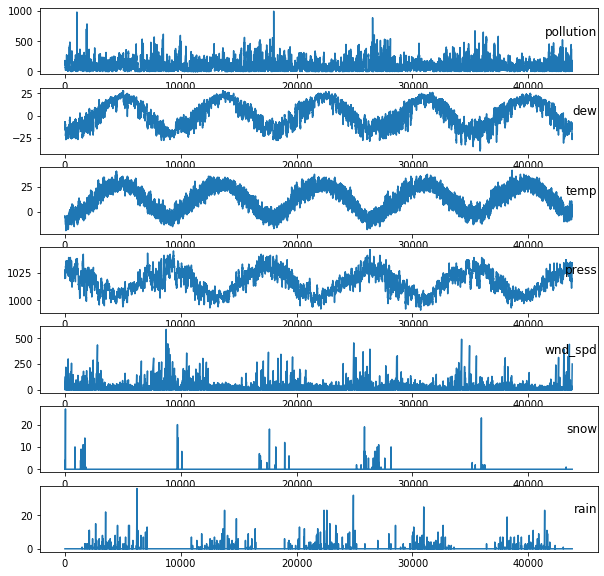

In [3]:
from pandas import read_csv
# load dataset
dataset = read_csv('local/data/pollution.csv', compression='gzip', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(10,10))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [4]:
dataset.columns[0]

'pollution'

## Exercise 1

Create three models: one based on conventional RNNs, one based on LSTM and a last one based on GRU units. Compare the performance of the models predicting one step forward. For all the models use one recurrent layer with 10 neurons.

### Solution:

The original data is organized in a matrix where rows are observations and columns are variables.



First of all, create a function to format the data as the model requires: [n_samples,n_times,n_features]

In [5]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [6]:
Eje_serie = np.arange(20)
print(Eje_serie)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [7]:
create_dataset(Eje_serie, look_back=3)

(array([[ 0,  1,  2],
        [ 1,  2,  3],
        [ 2,  3,  4],
        [ 3,  4,  5],
        [ 4,  5,  6],
        [ 5,  6,  7],
        [ 6,  7,  8],
        [ 7,  8,  9],
        [ 8,  9, 10],
        [ 9, 10, 11],
        [10, 11, 12],
        [11, 12, 13],
        [12, 13, 14],
        [13, 14, 15],
        [14, 15, 16],
        [15, 16, 17],
        [16, 17, 18]]),
 array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]))

#### But our dataset is Multivariate, so we need to make a small change to the former function:

In [8]:
def create_datasetMV(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [9]:
Eje_serie = np.r_[np.arange(20).reshape(1,-1),np.arange(20,40).reshape(1,-1)]
print(Eje_serie)

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]]


In [10]:
X,Y = create_datasetMV(Eje_serie.T, look_back=2)
X.shape,Y.shape

((18, 2, 2), (18,))

In [11]:
X[0,:,:]

array([[ 0, 20],
       [ 1, 21]])

In [12]:
Y[0]

2

Now we can define a function that help us we the partition of the data and the creation of training and testing sets.

In [13]:
from sklearn.preprocessing import MinMaxScaler
def DataPreparation(look_back):
    times = values.shape[0]
    # split into train and test sets
    train_size = int(times * 0.67)
    test_size = times - train_size
    train, test = values[0:train_size,groups], values[train_size-look_back:times,groups]
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    trainN = scaler.fit_transform(train)
    testN = scaler.transform(test)
    X_train, y_train = create_datasetMV(trainN, look_back)
    X_test, y_test = create_datasetMV(testN, look_back)
    # Defino un scaler sólo para polución
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train[:,0].reshape(-1,1))
    return X_train, y_train, X_test, y_test, scaler

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import datetime

In [24]:
def TrainModel(X_train,y_train,layer='SimpleRNN'):
    model = Sequential()
    if layer == 'LSTM':
        model.add(LSTM(20,activation = 'relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    elif layer == 'GRU':
        model.add(GRU(20,activation = 'relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    else:
        model.add(SimpleRNN(20,activation = 'relu',input_shape=(X_train.shape[1],X_train.shape[2])))
        
    model.add(Dense(1))
    Optimi = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=Optimi,loss='mse',metrics=['mae'])
    #-------------------------------------------------------------------------------------------------
    !rm -rf ./logs/ 
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    #-------------------------------------------------------------------------------------------------
    model.fit(X_train,y_train,epochs=20, verbose=1, callbacks=[tensorboard_callback])
    return model

In [25]:
from numpy.random import seed
#tf.keras.backend.clear_session()
seed(1)
tf.random.set_seed(2)
from sklearn.metrics import mean_squared_error
tf.keras.backend.clear_session()
look_back = 1

X_train, y_train, X_test, y_test, scaler = DataPreparation(look_back)
print(X_train.shape)
model = TrainModel(X_train,y_train)
y_est = model.predict(X_test)
print('RMSE con los datos normalizados')
print(np.sqrt(mean_squared_error(y_test.flatten(), y_est.flatten())))
print('RMSE con los datos en la magnitud original')
print(np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(y_est))))

(29345, 1, 7)
Train on 29345 samples
Epoch 1/20
29345/29345 [==============================] - 2s 67us/sample - loss: 0.0095 - mae: 0.0673
Epoch 2/20
29345/29345 [==============================] - 2s 55us/sample - loss: 0.0035 - mae: 0.0407
Epoch 3/20
29345/29345 [==============================] - 2s 55us/sample - loss: 0.0016 - mae: 0.0248
Epoch 4/20
29345/29345 [==============================] - 2s 54us/sample - loss: 0.0010 - mae: 0.0171
Epoch 5/20
29345/29345 [==============================] - 2s 55us/sample - loss: 9.1794e-04 - mae: 0.0153
Epoch 6/20
29345/29345 [==============================] - 2s 55us/sample - loss: 8.7723e-04 - mae: 0.0147
Epoch 7/20
29345/29345 [==============================] - 2s 57us/sample - loss: 8.5727e-04 - mae: 0.0145
Epoch 8/20
29345/29345 [==============================] - 2s 59us/sample - loss: 8.4729e-04 - mae: 0.0144
Epoch 9/20
29345/29345 [==============================] - 2s 57us/sample - loss: 8.4248e-04 - mae: 0.0144
Epoch 10/20
29345/29345 [

In [28]:
%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [27]:
#!kill 5063

In [35]:
def TrainModel2(X_train,y_train,layer='SimpleRNN'):
    model = Sequential()
    if layer == 'LSTM':
        model.add(LSTM(20,activation = 'relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    elif layer == 'GRU':
        model.add(GRU(20,activation = 'relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    else:
        model.add(SimpleRNN(20,activation = 'relu',input_shape=(X_train.shape[1],X_train.shape[2])))
        
    model.add(Dense(1))
    Optimi = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=Optimi,loss='mse',metrics=['mae'])
    #-------------------------------------------------------------------------------------------------
    #log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    #-------------------------------------------------------------------------------------------------
    #We could use validation_split=0.1
    stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    model.fit(X_train,y_train,epochs=20, validation_split=0.1, verbose=0, callbacks=[stop])
    return model

In [30]:
mse = np.zeros((3,5))
for i in range(1,6):
    for j,k in enumerate(['LSTM','GRU','SimpleRNN']):
        X_train, y_train, X_test, y_test, scaler = DataPreparation(i)
        model = TrainModel2(X_train,y_train,layer=k)
        y_est = model.predict(X_test)
        mse[j,i-1] = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(y_est)))

Train on 26410 samples, validate on 2935 samples
Epoch 1/20
26410/26410 [==============================] - 2s 82us/sample - loss: 0.0067 - mae: 0.0579 - val_loss: 0.0121 - val_mae: 0.0698
Epoch 2/20
26410/26410 [==============================] - 2s 60us/sample - loss: 0.0038 - mae: 0.0437 - val_loss: 0.0064 - val_mae: 0.0497
Epoch 3/20
26410/26410 [==============================] - 1s 56us/sample - loss: 0.0019 - mae: 0.0303 - val_loss: 0.0032 - val_mae: 0.0336
Epoch 4/20
26410/26410 [==============================] - 2s 59us/sample - loss: 0.0010 - mae: 0.0206 - val_loss: 0.0020 - val_mae: 0.0246
Epoch 5/20
26410/26410 [==============================] - 2s 61us/sample - loss: 8.2202e-04 - mae: 0.0165 - val_loss: 0.0017 - val_mae: 0.0214
Epoch 6/20
26410/26410 [==============================] - 2s 84us/sample - loss: 7.7658e-04 - mae: 0.0151 - val_loss: 0.0017 - val_mae: 0.0205
Epoch 7/20
26410/26410 [==============================] - 2s 64us/sample - loss: 7.6405e-04 - mae: 0.0145 - v

26410/26410 [==============================] - 1s 51us/sample - loss: 7.5857e-04 - mae: 0.0145 - val_loss: 0.0016 - val_mae: 0.0197
Epoch 18/20
26410/26410 [==============================] - 1s 49us/sample - loss: 7.5786e-04 - mae: 0.0145 - val_loss: 0.0016 - val_mae: 0.0192
Epoch 19/20
26410/26410 [==============================] - 1s 51us/sample - loss: 7.5681e-04 - mae: 0.0144 - val_loss: 0.0016 - val_mae: 0.0193
Train on 26409 samples, validate on 2935 samples
Epoch 1/20
26409/26409 [==============================] - 2s 89us/sample - loss: 0.0089 - mae: 0.0659 - val_loss: 0.0153 - val_mae: 0.0814
Epoch 2/20
26409/26409 [==============================] - 2s 71us/sample - loss: 0.0050 - mae: 0.0516 - val_loss: 0.0080 - val_mae: 0.0590
Epoch 3/20
26409/26409 [==============================] - 2s 89us/sample - loss: 0.0021 - mae: 0.0323 - val_loss: 0.0026 - val_mae: 0.0316
Epoch 4/20
26409/26409 [==============================] - 2s 77us/sample - loss: 0.0011 - mae: 0.0203 - val_loss: 

26409/26409 [==============================] - 1s 55us/sample - loss: 7.8185e-04 - mae: 0.0151 - val_loss: 0.0016 - val_mae: 0.0197
Epoch 15/20
26409/26409 [==============================] - 2s 58us/sample - loss: 7.7296e-04 - mae: 0.0149 - val_loss: 0.0016 - val_mae: 0.0198
Epoch 16/20
26409/26409 [==============================] - 1s 56us/sample - loss: 7.6776e-04 - mae: 0.0148 - val_loss: 0.0016 - val_mae: 0.0194
Epoch 17/20
26409/26409 [==============================] - 1s 57us/sample - loss: 7.6208e-04 - mae: 0.0147 - val_loss: 0.0016 - val_mae: 0.0192
Epoch 18/20
26409/26409 [==============================] - 1s 56us/sample - loss: 7.5743e-04 - mae: 0.0146 - val_loss: 0.0016 - val_mae: 0.0191
Epoch 19/20
26409/26409 [==============================] - 1s 55us/sample - loss: 7.5245e-04 - mae: 0.0144 - val_loss: 0.0016 - val_mae: 0.0195
Epoch 20/20
26409/26409 [==============================] - 2s 58us/sample - loss: 7.4840e-04 - mae: 0.0144 - val_loss: 0.0016 - val_mae: 0.0195
Trai

26408/26408 [==============================] - 2s 61us/sample - loss: 8.7613e-04 - mae: 0.0177 - val_loss: 0.0018 - val_mae: 0.0238
Epoch 11/20
26408/26408 [==============================] - 2s 61us/sample - loss: 8.5018e-04 - mae: 0.0172 - val_loss: 0.0018 - val_mae: 0.0232
Epoch 12/20
26408/26408 [==============================] - 2s 62us/sample - loss: 8.3529e-04 - mae: 0.0169 - val_loss: 0.0018 - val_mae: 0.0225
Epoch 13/20
26408/26408 [==============================] - 2s 61us/sample - loss: 8.1588e-04 - mae: 0.0165 - val_loss: 0.0018 - val_mae: 0.0223
Epoch 14/20
26408/26408 [==============================] - 2s 62us/sample - loss: 8.0884e-04 - mae: 0.0163 - val_loss: 0.0017 - val_mae: 0.0221
Epoch 15/20
26408/26408 [==============================] - 2s 64us/sample - loss: 7.9481e-04 - mae: 0.0160 - val_loss: 0.0018 - val_mae: 0.0225
Epoch 16/20
26408/26408 [==============================] - 2s 62us/sample - loss: 7.8828e-04 - mae: 0.0159 - val_loss: 0.0017 - val_mae: 0.0215
Epoc

26407/26407 [==============================] - 2s 68us/sample - loss: 9.3752e-04 - mae: 0.0185 - val_loss: 0.0018 - val_mae: 0.0236
Epoch 7/20
26407/26407 [==============================] - 2s 66us/sample - loss: 9.0563e-04 - mae: 0.0179 - val_loss: 0.0017 - val_mae: 0.0229
Epoch 8/20
26407/26407 [==============================] - 2s 69us/sample - loss: 8.7882e-04 - mae: 0.0174 - val_loss: 0.0017 - val_mae: 0.0223
Epoch 9/20
26407/26407 [==============================] - 2s 67us/sample - loss: 8.5572e-04 - mae: 0.0170 - val_loss: 0.0017 - val_mae: 0.0218
Epoch 10/20
26407/26407 [==============================] - 2s 68us/sample - loss: 8.3820e-04 - mae: 0.0166 - val_loss: 0.0016 - val_mae: 0.0210
Epoch 11/20
26407/26407 [==============================] - 2s 68us/sample - loss: 8.2400e-04 - mae: 0.0163 - val_loss: 0.0016 - val_mae: 0.0208
Epoch 12/20
26407/26407 [==============================] - 2s 67us/sample - loss: 8.1230e-04 - mae: 0.0161 - val_loss: 0.0016 - val_mae: 0.0206
Epoch 1

26406/26406 [==============================] - 2s 73us/sample - loss: 0.0019 - mae: 0.0312 - val_loss: 0.0026 - val_mae: 0.0334
Epoch 3/20
26406/26406 [==============================] - 2s 73us/sample - loss: 0.0013 - mae: 0.0240 - val_loss: 0.0022 - val_mae: 0.0280
Epoch 4/20
26406/26406 [==============================] - 2s 81us/sample - loss: 0.0011 - mae: 0.0212 - val_loss: 0.0020 - val_mae: 0.0259
Epoch 5/20
26406/26406 [==============================] - 2s 74us/sample - loss: 0.0010 - mae: 0.0197 - val_loss: 0.0019 - val_mae: 0.0249
Epoch 6/20
26406/26406 [==============================] - 2s 72us/sample - loss: 9.6920e-04 - mae: 0.0187 - val_loss: 0.0018 - val_mae: 0.0233
Epoch 7/20
26406/26406 [==============================] - 2s 74us/sample - loss: 9.2115e-04 - mae: 0.0178 - val_loss: 0.0017 - val_mae: 0.0230
Epoch 8/20
26406/26406 [==============================] - 2s 73us/sample - loss: 8.8598e-04 - mae: 0.0172 - val_loss: 0.0016 - val_mae: 0.0221
Epoch 9/20
26406/26406 [==

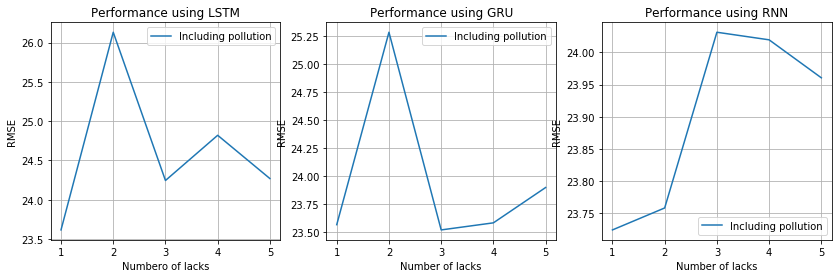

In [31]:
look_back = range(1,6)
plt.figure(figsize=(14,4))
plt.subplot(131)
plt.plot(look_back,mse[0,:],label='Including pollution')
plt.xlabel('Numbero of lacks')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
#---------------------------------------------------------
plt.title('Performance using LSTM')
plt.subplot(132)
plt.plot(look_back,mse[1,:],label='Including pollution')
plt.xlabel('Number of lacks')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
#---------------------------------------------------------
plt.title('Performance using GRU')
plt.subplot(133)
plt.plot(look_back,mse[2,:],label='Including pollution')
plt.xlabel('Number of lacks')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.title('Performance using RNN')
plt.show()

In [86]:
X_train, y_train, X_test, y_test, scaler = DataPreparation(3)
model = TrainModel2(X_train,y_train,'GRU')
y_est = model.predict(X_test)

Train on 26408 samples, validate on 2935 samples
Epoch 1/20
26408/26408 [==============================] - 6s 224us/sample - loss: 0.0045 - mae: 0.0447 - val_loss: 0.0029 - val_mae: 0.0300
Epoch 2/20
26408/26408 [==============================] - 6s 225us/sample - loss: 0.0011 - mae: 0.0187 - val_loss: 0.0022 - val_mae: 0.0246
Epoch 3/20
26408/26408 [==============================] - 5s 203us/sample - loss: 9.7861e-04 - mae: 0.0175 - val_loss: 0.0020 - val_mae: 0.0237
Epoch 4/20
26408/26408 [==============================] - 6s 244us/sample - loss: 9.3506e-04 - mae: 0.0169 - val_loss: 0.0019 - val_mae: 0.0228
Epoch 5/20
26408/26408 [==============================] - 7s 258us/sample - loss: 8.9607e-04 - mae: 0.0164 - val_loss: 0.0018 - val_mae: 0.0221
Epoch 6/20
26408/26408 [==============================] - 7s 250us/sample - loss: 8.5946e-04 - mae: 0.0160 - val_loss: 0.0017 - val_mae: 0.0213
Epoch 7/20
26408/26408 [==============================] - 5s 187us/sample - loss: 8.2923e-04 - 

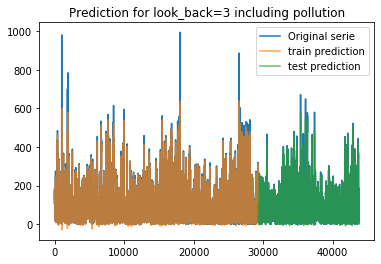

In [89]:
times = values.shape[0]
train_size = int(times * 0.67)
    
y_est_t = model.predict(X_train)
trainPredictPlot = np.empty_like(values[:,0])
trainPredictPlot[:] = np.nan
trainPredictPlot[3:train_size] = scaler.inverse_transform(y_est_t).flatten()
testPredictPlot = np.empty_like(values[:,0])
testPredictPlot[:] = np.nan
testPredictPlot[train_size:] = scaler.inverse_transform(y_est).flatten()
plt.figure()
plt.plot(values[:,0],label='Original serie')
plt.plot(trainPredictPlot,label='train prediction',alpha=0.7)
plt.plot(testPredictPlot,label='test prediction',alpha=0.7)
plt.title('Prediction for look_back=3 including pollution')
plt.legend()

### ¿Qué modificación debemos hacer para no incluir 'pollution' dentro de las variables de entrada?

In [32]:
def create_datasetMV_WP(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 1:]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def DataPreparation_WP(look_back):
    times = values.shape[0]
    # split into train and test sets
    train_size = int(times * 0.67)
    test_size = times - train_size
    train, test = values[0:train_size,groups], values[train_size-look_back:times,groups]
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    trainN = scaler.fit_transform(train)
    testN = scaler.transform(test)
    X_train, y_train = create_datasetMV_WP(trainN, look_back)
    X_test, y_test = create_datasetMV_WP(testN, look_back)
    # Defino un scaler sólo para polución
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train[:,0].reshape(-1,1))
    return X_train, y_train, X_test, y_test, scaler

In [33]:
mse2 = np.zeros((3,5))
for i in range(1,6):
    for j,k in enumerate(['LSTM','GRU','SimpleRNN']):
        X_train, y_train, X_test, y_test, scaler = DataPreparation_WP(i)
        model = TrainModel2(X_train,y_train,layer=k)
        y_est = model.predict(X_test)
        mse2[j,i-1] = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(y_est)))

Train on 26410 samples, validate on 2935 samples
Epoch 1/20
26410/26410 [==============================] - 2s 92us/sample - loss: 0.0093 - mae: 0.0684 - val_loss: 0.0165 - val_mae: 0.0835
Epoch 2/20
26410/26410 [==============================] - 2s 61us/sample - loss: 0.0070 - mae: 0.0612 - val_loss: 0.0154 - val_mae: 0.0796
Epoch 3/20
26410/26410 [==============================] - 2s 58us/sample - loss: 0.0068 - mae: 0.0603 - val_loss: 0.0148 - val_mae: 0.0781
Epoch 4/20
26410/26410 [==============================] - 2s 59us/sample - loss: 0.0067 - mae: 0.0595 - val_loss: 0.0143 - val_mae: 0.0767
Epoch 5/20
26410/26410 [==============================] - 2s 57us/sample - loss: 0.0065 - mae: 0.0589 - val_loss: 0.0140 - val_mae: 0.0757
Epoch 6/20
26410/26410 [==============================] - 2s 60us/sample - loss: 0.0065 - mae: 0.0585 - val_loss: 0.0139 - val_mae: 0.0751
Epoch 7/20
26410/26410 [==============================] - 2s 67us/sample - loss: 0.0064 - mae: 0.0580 - val_loss: 0.0

26410/26410 [==============================] - 1s 50us/sample - loss: 0.0060 - mae: 0.0555 - val_loss: 0.0115 - val_mae: 0.0708
Epoch 19/20
26410/26410 [==============================] - 1s 49us/sample - loss: 0.0060 - mae: 0.0555 - val_loss: 0.0116 - val_mae: 0.0708
Epoch 20/20
26410/26410 [==============================] - 1s 51us/sample - loss: 0.0060 - mae: 0.0555 - val_loss: 0.0123 - val_mae: 0.0716
Train on 26409 samples, validate on 2935 samples
Epoch 1/20
26409/26409 [==============================] - 2s 91us/sample - loss: 0.0111 - mae: 0.0731 - val_loss: 0.0183 - val_mae: 0.0868
Epoch 2/20
26409/26409 [==============================] - 2s 72us/sample - loss: 0.0070 - mae: 0.0600 - val_loss: 0.0156 - val_mae: 0.0788
Epoch 3/20
26409/26409 [==============================] - 2s 74us/sample - loss: 0.0066 - mae: 0.0588 - val_loss: 0.0144 - val_mae: 0.0763
Epoch 4/20
26409/26409 [==============================] - 2s 72us/sample - loss: 0.0065 - mae: 0.0583 - val_loss: 0.0140 - val

Epoch 16/20
26409/26409 [==============================] - 2s 57us/sample - loss: 0.0059 - mae: 0.0548 - val_loss: 0.0114 - val_mae: 0.0695
Epoch 17/20
26409/26409 [==============================] - 2s 58us/sample - loss: 0.0059 - mae: 0.0547 - val_loss: 0.0116 - val_mae: 0.0696
Epoch 18/20
26409/26409 [==============================] - 2s 57us/sample - loss: 0.0058 - mae: 0.0546 - val_loss: 0.0112 - val_mae: 0.0691
Epoch 19/20
26409/26409 [==============================] - 2s 59us/sample - loss: 0.0058 - mae: 0.0546 - val_loss: 0.0112 - val_mae: 0.0691
Epoch 20/20
26409/26409 [==============================] - 1s 57us/sample - loss: 0.0058 - mae: 0.0545 - val_loss: 0.0114 - val_mae: 0.0692
Train on 26408 samples, validate on 2935 samples
Epoch 1/20
26408/26408 [==============================] - 3s 102us/sample - loss: 0.0083 - mae: 0.0646 - val_loss: 0.0154 - val_mae: 0.0797
Epoch 2/20
26408/26408 [==============================] - 2s 81us/sample - loss: 0.0068 - mae: 0.0602 - val_los

26408/26408 [==============================] - 2s 62us/sample - loss: 0.0059 - mae: 0.0550 - val_loss: 0.0124 - val_mae: 0.0715
Epoch 14/20
26408/26408 [==============================] - 2s 63us/sample - loss: 0.0059 - mae: 0.0549 - val_loss: 0.0115 - val_mae: 0.0704
Epoch 15/20
26408/26408 [==============================] - 2s 64us/sample - loss: 0.0059 - mae: 0.0548 - val_loss: 0.0115 - val_mae: 0.0707
Epoch 16/20
26408/26408 [==============================] - 2s 63us/sample - loss: 0.0059 - mae: 0.0547 - val_loss: 0.0114 - val_mae: 0.0702
Epoch 17/20
26408/26408 [==============================] - 2s 64us/sample - loss: 0.0059 - mae: 0.0547 - val_loss: 0.0117 - val_mae: 0.0697
Epoch 18/20
26408/26408 [==============================] - 2s 62us/sample - loss: 0.0058 - mae: 0.0545 - val_loss: 0.0117 - val_mae: 0.0699
Epoch 19/20
26408/26408 [==============================] - 2s 62us/sample - loss: 0.0058 - mae: 0.0544 - val_loss: 0.0119 - val_mae: 0.0701
Epoch 20/20
26408/26408 [=======

26407/26407 [==============================] - 2s 67us/sample - loss: 0.0059 - mae: 0.0550 - val_loss: 0.0121 - val_mae: 0.0704
Epoch 11/20
26407/26407 [==============================] - 2s 66us/sample - loss: 0.0059 - mae: 0.0548 - val_loss: 0.0117 - val_mae: 0.0700
Epoch 12/20
26407/26407 [==============================] - 2s 66us/sample - loss: 0.0059 - mae: 0.0547 - val_loss: 0.0119 - val_mae: 0.0701
Epoch 13/20
26407/26407 [==============================] - 2s 68us/sample - loss: 0.0059 - mae: 0.0545 - val_loss: 0.0119 - val_mae: 0.0700
Epoch 14/20
26407/26407 [==============================] - 2s 69us/sample - loss: 0.0058 - mae: 0.0543 - val_loss: 0.0116 - val_mae: 0.0696
Epoch 15/20
26407/26407 [==============================] - 2s 67us/sample - loss: 0.0058 - mae: 0.0542 - val_loss: 0.0116 - val_mae: 0.0695
Epoch 16/20
26407/26407 [==============================] - 2s 70us/sample - loss: 0.0058 - mae: 0.0541 - val_loss: 0.0116 - val_mae: 0.0695
Epoch 17/20
26407/26407 [=======

26406/26406 [==============================] - 2s 74us/sample - loss: 0.0061 - mae: 0.0562 - val_loss: 0.0121 - val_mae: 0.0717
Epoch 8/20
26406/26406 [==============================] - 2s 76us/sample - loss: 0.0060 - mae: 0.0559 - val_loss: 0.0116 - val_mae: 0.0711
Epoch 9/20
26406/26406 [==============================] - 2s 75us/sample - loss: 0.0060 - mae: 0.0557 - val_loss: 0.0124 - val_mae: 0.0717
Epoch 10/20
26406/26406 [==============================] - 2s 75us/sample - loss: 0.0060 - mae: 0.0555 - val_loss: 0.0123 - val_mae: 0.0715
Epoch 11/20
26406/26406 [==============================] - 2s 76us/sample - loss: 0.0059 - mae: 0.0553 - val_loss: 0.0111 - val_mae: 0.0704
Epoch 12/20
26406/26406 [==============================] - 2s 75us/sample - loss: 0.0059 - mae: 0.0553 - val_loss: 0.0117 - val_mae: 0.0702
Epoch 13/20
26406/26406 [==============================] - 2s 76us/sample - loss: 0.0059 - mae: 0.0552 - val_loss: 0.0112 - val_mae: 0.0699
Epoch 14/20
26406/26406 [=========

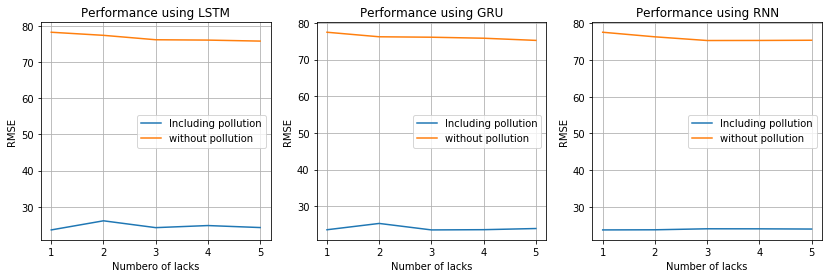

In [34]:
look_back = range(1,6)
plt.figure(figsize=(14,4))
plt.subplot(131)
plt.plot(look_back,mse[0,:],label='Including pollution')
plt.plot(look_back,mse2[0,:],label='without pollution')
plt.xlabel('Numbero of lacks')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
#---------------------------------------------------------
plt.title('Performance using LSTM')
plt.subplot(132)
plt.plot(look_back,mse[1,:],label='Including pollution')
plt.plot(look_back,mse2[1,:],label='without pollution')
plt.xlabel('Number of lacks')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
#----------------------------------------------------------
plt.title('Performance using GRU')
plt.subplot(133)
plt.plot(look_back,mse[2,:],label='Including pollution')
plt.plot(look_back,mse2[2,:],label='without pollution')
plt.xlabel('Number of lacks')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.title('Performance using RNN')
plt.show()

## Excercise 2

Repeat the exercise using crossvalidation and include the confidence interval in the plot.

In [38]:
def DataPreparationCV(look_back,train_index):
    times = values.shape[0]
    # split into train and test sets
    train_size = len(train_index)
    test_size = times - train_size
    train, test = values[0:train_size,groups], values[train_size-look_back:times,groups]
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    trainN = scaler.fit_transform(train)
    testN = scaler.transform(test)
    X_train, y_train = create_datasetMV(trainN, look_back)
    X_test, y_test = create_datasetMV(testN, look_back)
    # Defino un scaler sólo para polución
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train[:,0].reshape(-1,1))
    return X_train, y_train, X_test, y_test, scaler

def DataPreparationCV_WP(look_back,train_index):
    times = values.shape[0]
    # split into train and test sets
    train_size = len(train_index)
    test_size = times - train_size
    train, test = values[0:train_size,groups], values[train_size-look_back:times,groups]
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    trainN = scaler.fit_transform(train)
    testN = scaler.transform(test)
    X_train, y_train = create_datasetMV_WP(trainN, look_back)
    X_test, y_test = create_datasetMV_WP(testN, look_back)
    # Defino un scaler sólo para polución
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train[:,0].reshape(-1,1))
    return X_train, y_train, X_test, y_test, scaler

In [39]:
from sklearn.model_selection import TimeSeriesSplit
times = values.shape[0]
X = np.arange(times)
tscv = TimeSeriesSplit(n_splits=5)
l=-1
mse3 = np.zeros((2,5,5))
for train_index, test_index in tscv.split(X): 
    l += 1
    for i in range(1,6):
        for j,k in enumerate(['LSTM','GRU',]):
            X_train, y_train, X_test, y_test, scaler = DataPreparationCV(i,train_index)
            model = TrainModel2(X_train,y_train,layer=k)
            y_est = model.predict(X_test)
            mse3[j,i-1,l] = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(y_est)))

In [40]:
from sklearn.model_selection import TimeSeriesSplit
times = values.shape[0]
X = np.arange(times)
tscv = TimeSeriesSplit(n_splits=5)
l=-1
mse4 = np.zeros((2,5,5))
for train_index, test_index in tscv.split(X): 
    l += 1
    for i in range(1,6):
        for j,k in enumerate(['LSTM','GRU',]):
            X_train, y_train, X_test, y_test, scaler = DataPreparationCV_WP(i,train_index)
            model = TrainModel2(X_train,y_train,layer=k)
            y_est = model.predict(X_test)
            mse4[j,i-1,l] = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(y_est)))

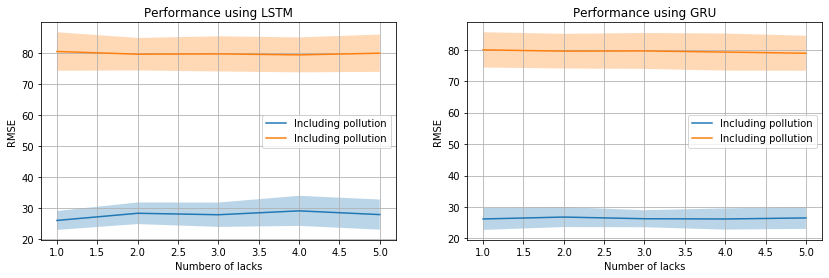

In [43]:
meanRMSE3 = np.mean(mse3,axis=2)
stdRMSE3 =  np.std(mse3,axis=2)
meanRMSE4 = np.mean(mse4,axis=2)
stdRMSE4 =  np.std(mse4,axis=2)
look_back = range(1,6)

fig, ax = plt.subplots(figsize=(14,4))
plt.subplot(121)
plt.plot(look_back,meanRMSE3[0,:],label='Including pollution')
plt.fill_between(look_back, meanRMSE3[0,:] + stdRMSE3[0,:], meanRMSE3[0,:] - stdRMSE3[0,:], alpha=0.3,edgecolor="")
plt.plot(look_back,meanRMSE4[0,:],label='Including pollution')
plt.fill_between(look_back, meanRMSE4[0,:] + stdRMSE4[0,:], meanRMSE4[0,:] - stdRMSE4[0,:], alpha=0.3, edgecolor="")
plt.xlabel('Numbero of lacks')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.title('Performance using LSTM')
#------------------------------------------------------------
plt.subplot(122)
plt.plot(look_back,meanRMSE3[1,:],label='Including pollution')
plt.fill_between(look_back, meanRMSE3[1,:] + stdRMSE3[1,:], meanRMSE3[1,:] - stdRMSE3[1,:], alpha=0.3, edgecolor="")
plt.plot(look_back,meanRMSE4[1,:],label='Including pollution')
plt.fill_between(look_back, meanRMSE4[1,:] + stdRMSE4[1,:], meanRMSE4[1,:] - stdRMSE4[1,:], alpha=0.3, edgecolor="")
plt.xlabel('Number of lacks')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.title('Performance using GRU')
plt.show()

## Excercise 3

Create one model based on LSTM cells to predict air pollution [3,6,12] times ahead. Create a Encoder-Decoder architecture to make the predictions. Use a network with one GRU layer of 30 cells.

### Vamos a resolverlo para 3 tiempos hacia adelante

#### Nuevamente tenemos que modificar las funciones para darle el formato adecuado a los datos

In [48]:
def create_datasetMV_TimesAhead(dataset,look_back=1, n_steps_ahead=1):
    overlap = n_steps_ahead
    dataX, dataY, dataX2 = [], [], []
    tem = look_back + n_steps_ahead - overlap
    for i in range(int((dataset.shape[0]- tem)/overlap)):
        startx = i*overlap
        endx = startx + look_back
        starty = endx
        endy = endx + n_steps_ahead
        a = dataset[startx:endx, :]
        dataX.append(a)
        dataY.append(dataset[starty:endy, 0])
    return np.array(dataX), np.array(dataY)

def DataPreparation_TimesAhead(look_back,n_steps_ahead):
    times = values.shape[0]
    # split into train and test sets
    train_size = int(times * 0.67)
    test_size = times - train_size
    train, test = values[0:train_size,groups], values[train_size-look_back:times,groups]
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    trainN = scaler.fit_transform(train)
    testN = scaler.transform(test)
    X_train, y_train = create_datasetMV_TimesAhead(trainN, look_back=look_back,n_steps_ahead=n_steps_ahead)
    X_test, y_test = create_datasetMV_TimesAhead(testN, look_back=look_back,n_steps_ahead=n_steps_ahead)
    # Defino un scaler sólo para polución
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train[:,0].reshape(-1,1))
    return X_train, y_train, X_test, y_test, scaler

In [52]:
Eje_serie = np.r_[np.arange(20).reshape(1,-1),np.arange(20,40).reshape(1,-1)]
print(Eje_serie)

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]]


In [49]:
X,Y = create_datasetMV_TimesAhead(Eje_serie.T, look_back=3, n_steps_ahead=2)
X.shape,Y.shape

((8, 3, 2), (8, 2))

In [50]:
X[0,:,:]

array([[ 0, 20],
       [ 1, 21],
       [ 2, 22]])

In [53]:
Y[0,:]

array([3, 4])

In [55]:
from tensorflow.keras.layers import RepeatVector, TimeDistributed

In [59]:
seed(1)
tf.random.set_seed(2)
from sklearn.metrics import mean_squared_error
tf.keras.backend.clear_session()
look_back = 3
n_steps_ahead = 3
X_train, y_train, X_test, y_test, scaler = DataPreparation_TimesAhead(look_back,n_steps_ahead)
print(X_train.shape)
#---------------------------------------------------------------------
model = Sequential()
model.add(GRU(30,activation = 'relu',input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(RepeatVector(n_steps_ahead))  
model.add(TimeDistributed(Dense(1)))
#----------------------------------------------------------------------
Optimi = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=Optimi,loss='mse',metrics=['mae'])
#-------------------------------------------------------------------------------------------------
!rm -rf ./logs/ 
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
#-------------------------------------------------------------------------------------------------
model.fit(X_train,y_train,epochs=50, verbose=1, validation_split=0.1,callbacks=[tensorboard_callback,stop])
#---------------------------------------------------------------------

(9781, 3, 7)
Train on 8802 samples, validate on 979 samples
Epoch 1/50
8802/8802 [==============================] - 2s 174us/sample - loss: 0.0104 - mae: 0.0747 - val_loss: 0.0135 - val_mae: 0.0723
Epoch 2/50
8802/8802 [==============================] - 1s 103us/sample - loss: 0.0041 - mae: 0.0439 - val_loss: 0.0083 - val_mae: 0.0559
Epoch 3/50
8802/8802 [==============================] - 1s 110us/sample - loss: 0.0027 - mae: 0.0356 - val_loss: 0.0059 - val_mae: 0.0453
Epoch 4/50
8802/8802 [==============================] - 1s 108us/sample - loss: 0.0021 - mae: 0.0297 - val_loss: 0.0046 - val_mae: 0.0397
Epoch 5/50
8802/8802 [==============================] - 1s 139us/sample - loss: 0.0018 - mae: 0.0269 - val_loss: 0.0040 - val_mae: 0.0364
Epoch 6/50
8802/8802 [==============================] - 1s 107us/sample - loss: 0.0018 - mae: 0.0254 - val_loss: 0.0038 - val_mae: 0.0350
Epoch 7/50
8802/8802 [==============================] - 1s 116us/sample - loss: 0.0017 - mae: 0.0245 - val_loss:

In [60]:
%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [62]:
y_est = model.predict(X_test)
print('RMSE con los datos normalizados')
print(np.sqrt(mean_squared_error(y_test.flatten(), y_est.flatten())))
print('RMSE con los datos en la magnitud original')
print(np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(y_est.flatten().reshape(-1,1)))))

RMSE con los datos normalizados
0.03540081819713403
RMSE con los datos en la magnitud original
35.18841326140602


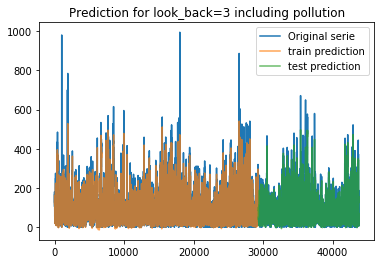

In [66]:
times = values.shape[0]
train_size = int(times * 0.67)
    
y_est_t = model.predict(X_train)
trainPredictPlot = np.empty_like(values[:,0])
trainPredictPlot[:] = np.nan
trainPredictPlot[3:train_size] = scaler.inverse_transform(y_est_t.flatten().reshape(-1,1)).flatten()
testPredictPlot = np.empty_like(values[:,0])
testPredictPlot[:] = np.nan
testPredictPlot[train_size:] = scaler.inverse_transform(y_est.flatten().reshape(-1,1)).flatten()
plt.figure()
plt.plot(values[:,0],label='Original serie')
plt.plot(trainPredictPlot,label='train prediction',alpha=0.7)
plt.plot(testPredictPlot,label='test prediction',alpha=0.7)
plt.title('Prediction for look_back=3 including pollution')
plt.legend()